# Video Face Manipulation Detection Through Ensemble of CNNs
Image and Sound Processing Lab - Politecnico di Milano
- Nicolò Bonettini
- Edoardo Daniele Cannas
- Sara Mandelli
- Luca Bondi
- Paolo Bestagini


In [1]:
!pip install efficientnet_pytorch
!pip install albumentations==0.4.6

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=4f82278cdef730feedf30be2a97287596b73df65f24d5dbe9e51f32af557c5a1
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch
     |████████████████████████████████| 122kB 6.0MB/s 
     |████████████████████████████████| 952kB 7.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=1823f1c076f133782bbe76ec5abd4ab28f368d8fcad3352c65e520978c42840f
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentation

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd ./drive/My\ Drive/icpr2020dfdc

Mounted at /content/drive
/content/drive/My Drive/icpr2020dfdc


In [3]:
import torch
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
from scipy.special import expit

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet,weights
from isplutils import utils

In [31]:
# test[0][0]
# !pwd
!cd weights/binclass; pwd

/content/drive/My Drive/icpr2020dfdc/weights/binclass


In [35]:
!python3 predict.py --path ../test_dataset/real/zuduvanawx.mp4 --modelsToEval Xception,EfficientNetB4,EfficientNetB4ST,EfficientNetAutoAttB4,EfficientNetAutoAttB4ST
# !cat predict.py

/content/drive/My Drive/icpr2020dfdc
<class 'collections.OrderedDict'>
<class 'collections.OrderedDict'>
Loaded pretrained weights for efficientnet-b4
<class 'collections.OrderedDict'>
Loaded pretrained weights for efficientnet-b4
<class 'collections.OrderedDict'>
Loaded pretrained weights for efficientnet-b4
<class 'collections.OrderedDict'>
Loaded pretrained weights for efficientnet-b4
Evaluating models: ['Xception', 'EfficientNetB4', 'EfficientNetB4ST', 'EfficientNetAutoAttB4', 'EfficientNetAutoAttB4ST']
[0.009468945, 0.010374964, 0.028474962, 0.026120601, 0.016907731]


In [ ]:
with open('../weights/binclass/net-EfficientNetB4_traindb-dfdc-35-5-10_face-scale_size-224_seed-41_nonTriplet/bestval.pth', 'rb') as f:
  read = torch.load(f)
print('last', read['train_loss'], read['val_loss'])

last 56.1859386596534 0.1514419519253486


## Parameters

In [ ]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetAutoAttB4ST'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'DFDC'

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224
frames_per_video = 32

## Initialization

In [ ]:
with open('../weights/binclass/net-EfficientNetAutoAttB4ST_traindb-dfdc-35-5-10_face-scale_size-224_seed-41/bestval.pth', 'rb') as f:
  net_new = torch.load(f) if torch.cuda.is_available() else torch.load(f, map_location=torch.device('cpu'))

In [15]:
with open('../weights/binclass/net-EfficientNetAutoAttB4_traindb-dfdc-35-5-10_face-scale_size-224_seed-41_nonTriplet/bestval.pth', 'rb') as f:
  nonST_net = torch.load(f) if torch.cuda.is_available() else torch.load(f, map_location=torch.device('cpu'))

In [ ]:
print(net_new['train_loss'], net_new['val_loss'])

1.8882383604650386 0.1767036909819429


In [16]:
print(nonST_net['train_loss'], net_new['val_loss'])

0.9959247258811956 0.1767036909819429


In [ ]:
help(net_new)

In [17]:
nonST_model = getattr(fornet,'EfficientNetAutoAttB4')().eval().to(device)
nonST_model.load_state_dict(nonST_net['net'])

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [ ]:
# model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(net_new['net'])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [ ]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [ ]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

## Detect faces

In [9]:
import pickle
with open('../test_data_list.pickle', 'rb') as f:
  test = pickle.load(f)

In [21]:
test[0]

('zuduvanawx.mp4', 'dbkrfxlell.mp4')

In [ ]:
# test all 
real_corr = 0
fake_corr = 0
for real, fake in test:
  vid_real_faces = face_extractor.process_video('../../test_dataset/real/'+real)
  vid_fake_faces = face_extractor.process_video('../../test_dataset/fake/'+fake)

  faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
  faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

  with torch.no_grad():
      faces_real_pred = net(faces_real_t.to(device)).cpu().numpy().flatten()
      faces_fake_pred = net(faces_fake_t.to(device)).cpu().numpy().flatten()
  real_corr += 1 if expit(faces_real_pred.mean()) < 0.5 else 0
  fake_corr += 1 if expit(faces_fake_pred.mean()) >= 0.5 else 0

In [ ]:
print('accuracy for real:', real_corr / len(test) * 100)
print('accuracy for fake:', fake_corr / len(test) * 100)
print('accuracy overall:', (real_corr+fake_corr) / len(test) * 50)

accuracy for real: 100.0
accuracy for fake: 83.22580645161291
accuracy overall: 91.61290322580645


In [ ]:
print(real_corr, fake_corr)

155 129


In [22]:
vid_real_faces = face_extractor.process_video('../../test_dataset/real/'+test[0][0])
vid_fake_faces = face_extractor.process_video('../../test_dataset/fake/'+test[0][1])

In [23]:
im_real_face = vid_real_faces[0]['faces'][0]
im_fake_face = vid_fake_faces[0]['faces'][0]

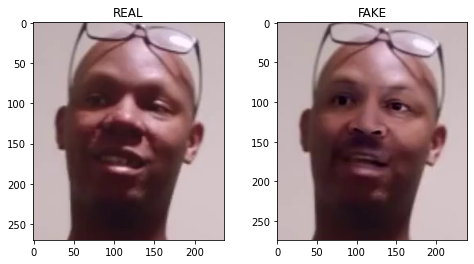

In [24]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE');

## Predict scores for each frame

In [ ]:
nonST_model

In [27]:
# For each frame, we consider the face with the highest confidence score found by BlazeFace (= frame['faces'][0])
faces_real_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_real_faces if len(frame['faces'])] )
faces_fake_t = torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in vid_fake_faces if len(frame['faces'])] )

with torch.no_grad():
    faces_real_pred = nonST_model(faces_real_t.to(device)).cpu().numpy().flatten()
    faces_fake_pred = nonST_model(faces_fake_t.to(device)).cpu().numpy().flatten()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


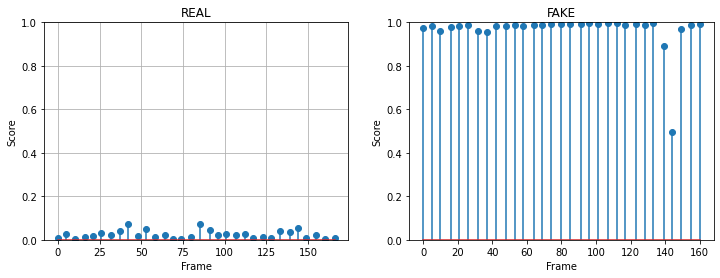

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].stem([f['frame_idx'] for f in vid_real_faces if len(f['faces'])],expit(faces_real_pred),use_line_collection=True)
ax[0].set_title('REAL')
ax[0].set_xlabel('Frame')
ax[0].set_ylabel('Score')
ax[0].set_ylim([0,1])
ax[0].grid(True)

ax[1].stem([f['frame_idx'] for f in vid_fake_faces if len(f['faces'])],expit(faces_fake_pred),use_line_collection=True)
ax[1].set_title('FAKE')
ax[1].set_xlabel('Frame')
ax[1].set_ylabel('Score')
ax[1].set_ylim([0,1])
ax[1].set_yticks([0,1],['REAL','FAKE']);

In [28]:
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 0.0261
Average score for FAKE face: 0.9984


In [ ]:
"""
Print average scores.
An average score close to 0 predicts REAL. An average score close to 1 predicts FAKE.
"""
print('Average score for REAL video: {:.4f}'.format(expit(faces_real_pred.mean())))
print('Average score for FAKE face: {:.4f}'.format(expit(faces_fake_pred.mean())))

Average score for REAL video: 0.0169
Average score for FAKE face: 0.9847


In [ ]:
# Xception -> corr
Average score for REAL video: 0.0095
Average score for FAKE face: 0.9952

In [ ]:
# effi net B4
Average score for REAL video: 0.0104
Average score for FAKE face: 0.9979

In [ ]:
# effi net B4 ST method
Average score for REAL video: 0.0285
Average score for FAKE face: 0.9976

In [ ]:
# effi net B4 Auto Att
Average score for REAL video: 0.0261
Average score for FAKE face: 0.9984

In [ ]:
# effit net B4 Auto Att ST method
Average score for REAL video: 0.0169
Average score for FAKE face: 0.9847